In [1]:
# Imports
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
from sklearn.utils import shuffle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from tqdm import tqdm

%matplotlib inline


In [2]:
# Load MNIST and shuffle
mnist = fetch_mldata('MNIST original', data_home="mnist/mnist")

x = mnist["data"]
y = mnist["target"]

x = x.reshape(-1, 1, 28, 28)
x = x.astype(np.float32)
x /= x.max()

y = y.astype(np.int)

x, y = shuffle(x, y, random_state=0)

In [3]:
# Def Net
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.dr_rate = 0.3
        
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=32, 
                               kernel_size=3, 
                               stride=2,
                               padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(in_channels=32,
                               out_channels=64, 
                               kernel_size=3, 
                               stride=2,
                               padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(in_channels=64,
                               out_channels=128, 
                               kernel_size=3, 
                               stride=2,
                               padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.fc1 = nn.Linear(in_features=128 * 4 * 4, 
                             out_features=512)
        
        self.fc2 = nn.Linear(in_features=512,
                             out_features=10)

    
    def dr_rate(self, dr_rate):
        self.dr_rate = dr_rate

    def forward(self, x):
        dropout = nn.Dropout(p=self.dr_rate)
        # Convolutional Part
        x = dropout(F.leaky_relu(self.conv1(x), negative_slope=.1))
        x = self.bn1(x)
        x = dropout(F.leaky_relu(self.conv2(x), negative_slope=.1))
        x = self.bn2(x)
        x = dropout(F.leaky_relu(self.conv3(x), negative_slope=.1))
        x = self.bn3(x)
        
        # Flatten
        x = x.view(-1, 128 * 4 * 4)
        # Dense Layers
        x = dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [4]:
# Def Generator
class Generator(object):
    def __init__(self, x, y, start=0, end=1, batch_size=8):
        self.x = x
        self.y = y
        self.start = start
        self.end = end
        self.batch_size = batch_size
        self._get_ids()
        
    def _get_ids(self):
        """
        Select Element from start to end
        """
        max_len = self.x.shape[0]
        first_element = self.start * max_len
        self.first_element = int(first_element)
        last_element = self.end * max_len
        self.last_element = int(last_element)
        self._ids = np.arange(self.first_element, self.last_element)
        self.x = self.x[self.first_element:self.last_element]
        self.y = self.y[self.first_element:self.last_element]
    
    def _make_pop_list(self):
        """
        Creates a popable List
        """
        self.pop_list = np.copy(self._ids-self.first_element)
        np.random.shuffle(self.pop_list)
        self.pop_list_len = int(len(self.pop_list)/self.batch_size) * self.batch_size
        self.pop_list = self.pop_list[0:self.pop_list_len]
        self.pop_list = self.pop_list.reshape(-1, self.batch_size)
        self.pop_list = list(self.pop_list)
    
    def __next__(self):
        try:
            ids = self.pop_list.pop()
        except:
            self._make_pop_list()
            ids = self.pop_list.pop()
        return self.x[ids], self.y[ids]
            

In [5]:
# Def Tracking
def get_history(network, generator):
    x_test, y_test = next(generator) 
    x_test = Variable(torch.from_numpy(x_test).cuda())
    y_test = Variable(torch.from_numpy(y_test).cuda())

    y_pred = net(x_test)
    
    _, predicted = torch.max(y_pred.data, 1)
    num_correct = (predicted == y_test.data).sum()
    acc = num_correct / batch_size
    
    loss = criterion(y_pred, y_test)
    return float(acc), float(loss.data)

In [13]:
# Def ALP-Functions
def get_noise(shape):
    epsilon = 1e-16 # numerical stability
    d = torch.randn(shape)
    d = l2_norm(d)
    d = Variable(d.cuda())
    d.requires_grad=True
    return d

def l2_norm(d):
    norm = torch.sum((d ** 2).view(batch_size,-1),dim=1)
    norm = torch.sqrt(norm + 0.000001)
    d /= norm.view(-1,1,1,1)
    return d

def ln_norm(d):
    norm = torch.max((d).view(batch_size,-1),dim=1)[0]
    d /= norm.view(-1,1,1,1)
    return d

In [56]:
# Globale Variables
batch_size = 8
n_steps = 10000

In [57]:
# ALP Variables
ALP = True
w_noise = 1 # wichtung für noise || noise *= w
w_attack = 1  # wichtung für attacke

In [58]:
# Instanziere Netwerk
net = Net()
net.cuda();

In [59]:
# Instanziere Generatoron
generator_train = Generator(x=x, y=y, start=0, end=0.001, batch_size=batch_size)
generator_alp = Generator(x=x, y=y, start=0.1, end=0.4, batch_size=batch_size)
generator_test = Generator(x=x, y=y, start=0.5, end=1, batch_size=batch_size)

In [60]:
# Erstelle Verluste
criterion = nn.CrossEntropyLoss()
net_optimizer = optim.RMSprop(net.parameters(), lr=0.0001)
l2_loss = nn.MSELoss()
kl_div = nn.KLDivLoss()

In [61]:
# Train net on real
train_loss = []
train_acc = []
test_loss = []
test_acc = []
alp_loss = []

for c in tqdm(range(n_steps)):
    # ALP Training
    if ALP:
        net_optimizer.zero_grad()
        x_alp, _ = next(generator_alp)
        x_alp = Variable(torch.from_numpy(x_alp).cuda())

        clean_pred = net(x_alp).detach()

        noise = get_noise(x_alp.shape)
        x_noisy = x_alp + noise * w_noise
        x_noisy = torch.clamp(x_noisy, 0 ,1)
        
        net.eval()
        noisy_pred = net(x_noisy)

        distance = l2_loss(F.softmax(noisy_pred), F.softmax(clean_pred))
        distance.backward()

        # Diese Zeile ist nur wegen einem bug nowendig
        attack = noise.grad.cpu().data.numpy()
        net_optimizer.zero_grad()

        attack = Variable(torch.from_numpy(attack).cuda())
        attack = ln_norm(attack)
        attack_pred = net(torch.clamp(x_alp + attack * w_attack, 0 ,1))
        
        loss = l2_loss(F.softmax(attack_pred), F.softmax(clean_pred))
        if c%10==9:
            alp_loss.append(loss.data)
        net.train()
    # Normal Training
    net_optimizer.zero_grad()
    x_train, y_train = next(generator_train) 
    x_train = Variable(torch.from_numpy(x_train).cuda())
    y_train = Variable(torch.from_numpy(y_train).cuda())

    y_pred = net(x_train)
    if ALP: loss += criterion(y_pred, y_train)
    else: loss = criterion(y_pred, y_train)
    loss.backward()
    net_optimizer.step()
    
    if c%10==9:
        acc, loss = get_history(net, generator_train)
        train_loss.append(loss)
        train_acc.append(acc)
        
        
        acc, loss = get_history(net, generator_test)
        test_loss.append(loss)
        test_acc.append(acc)


  0%|          | 0/10000 [00:00<?, ?it/s]/mnt/fs2/home/alook/anaconda2/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/mnt/fs2/home/alook/anaconda2/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
100%|██████████| 10000/10000 [01:07<00:00, 147.36it/s]


In [62]:
# Def Plotting Helfer
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

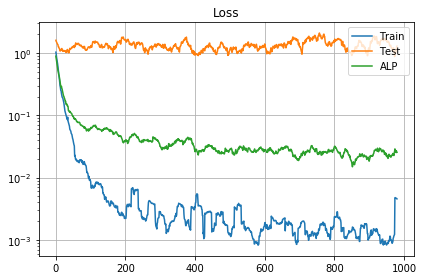

In [63]:
# Plot Loss
plt.title("Loss")
plt.semilogy(running_mean(train_loss, 20), label="Train")
plt.semilogy(running_mean(test_loss, 20), label="Test")
plt.semilogy(running_mean(alp_loss, 20), label="ALP")
plt.legend(loc=1)
plt.grid()
plt.tight_layout()

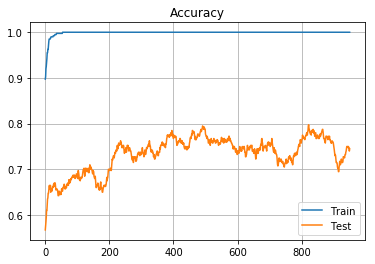

In [64]:
# Plot Acc
plt.title("Accuracy")
plt.plot(running_mean(train_acc, 50), label="Train")
plt.plot(running_mean(test_acc, 50), label="Test")
plt.grid()
plt.legend(loc=4)